In [1]:
import re
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

neuron_data = pd.read_excel(r'Data\NeuronType.xls')
conn_data = pd.read_excel(r'Data\NeuronConnect.xls')

neuron_to_id = {} #neuron_to_id[neuron] = number in table from 0 to 278
id_to_neuron = {} #id_to_neuron[id] = corresponded neuron
neuron_type = {} #neuron_type[neuron] = position of neuron (H - head, M - middle, T - tail)
nodes = [] #nodes of the network
type_to_id = {'H': 0, 'M': 1, 'T':2} #type_to_id[type] = id, id devided by 2 = color
id_to_type = dict((v,k) for k,v in type_to_id.items()) #id_to_type[id] = type

for ids in neuron_data['Id']: #collecting data
    neuron_to_id[neuron_data['Neuron'][ids]] = ids
    id_to_neuron[ids] = neuron_data['Neuron'][ids]
    nodes.append(neuron_data['Neuron'][ids])
    neuron_type[neuron_data['Neuron'][ids]] = neuron_data['Soma Region'][ids]
    
    
edges = [] #edges of the network
for i in range(len(conn_data['Source'])): #collecting correct edges
    s = conn_data['Source'][i]
    t = conn_data['Target'][i]
    if(s in neuron_to_id.keys() and t in neuron_to_id.keys()): #edges sholud by in from and to neurons at NeuronType.xls
        edges.append((s, t))
        
print("Current edges = ", len(edges), ", Edges in table = ", len(conn_data['Source']))

Current edges =  6264 , Edges in table =  6417


In [2]:
bad_edges = [] #check what edges are thrown
for i in range(len(conn_data['Source'])):
    s = conn_data['Source'][i]
    t = conn_data['Target'][i]
    if not (s in neuron_to_id.keys() and t in neuron_to_id.keys()):
        bad_edges.append((s, t)) 
        
bad_edges #throw neuro-muscular junctions

[('AS02', 'NMJ'),
 ('AS03', 'NMJ'),
 ('AS04', 'NMJ'),
 ('AS05', 'NMJ'),
 ('AS06', 'NMJ'),
 ('AS09', 'NMJ'),
 ('AS11', 'NMJ'),
 ('AVFL', 'NMJ'),
 ('AVFR', 'NMJ'),
 ('AVKR', 'NMJ'),
 ('AVKR', 'NMJ'),
 ('AVL', 'NMJ'),
 ('DA01', 'NMJ'),
 ('DA02', 'NMJ'),
 ('DA03', 'NMJ'),
 ('DA04', 'NMJ'),
 ('DA05', 'NMJ'),
 ('DA06', 'NMJ'),
 ('VC01', 'NMJ'),
 ('VC03', 'NMJ'),
 ('AS01', 'NMJ'),
 ('DA09', 'NMJ'),
 ('DB01', 'NMJ'),
 ('DB02', 'NMJ'),
 ('DB03', 'NMJ'),
 ('DB04', 'NMJ'),
 ('DD01', 'NMJ'),
 ('DD02', 'NMJ'),
 ('DD03', 'NMJ'),
 ('DD05', 'NMJ'),
 ('DD06', 'NMJ'),
 ('DVB', 'NMJ'),
 ('DVB', 'NMJ'),
 ('HSNL', 'NMJ'),
 ('HSNR', 'NMJ'),
 ('HSNR', 'NMJ'),
 ('IL1DL', 'NMJ'),
 ('IL1DL', 'NMJ'),
 ('IL1DR', 'NMJ'),
 ('IL1DR', 'NMJ'),
 ('IL1L', 'NMJ'),
 ('IL1L', 'NMJ'),
 ('IL1R', 'NMJ'),
 ('IL1R', 'NMJ'),
 ('IL1VL', 'NMJ'),
 ('IL1VL', 'NMJ'),
 ('IL1VR', 'NMJ'),
 ('IL1VR', 'NMJ'),
 ('PDA', 'NMJ'),
 ('PDB', 'NMJ'),
 ('PLNL', 'NMJ'),
 ('PVNL', 'NMJ'),
 ('PVNL', 'NMJ'),
 ('PVNR', 'NMJ'),
 ('PVNR', 'NMJ'),
 ('RID'

In [3]:
#create network
G_base = nx.DiGraph() #base graph sholuldn't be changed during code
G_d = nx.DiGraph() #directed graph we can change it
G_u = nx.Graph() #undirected graph corresponded to G_d

# add nodes
for n in nodes:
    G_d.add_node(n)
    G_u.add_node(n)
    G_base.add_node(n)

# add edges
for i in range(len(edges)):
    G_d.add_edge(edges[i][0], edges[i][1])
    G_u.add_edge(edges[i][0], edges[i][1])
    G_base.add_edge(edges[i][0], edges[i][1])  

#check that all nodes have edges
if len([i for i in nx.degree_centrality(G_u).keys() if nx.degree_centrality(G_u)[i] == 0]) == 0:
    print("Good: All nodes have edges")
else: 
    print("Bad: There are not connected nodes")

Good: All nodes have edges


SIBDL - H , VD08 - M , PLNR - T


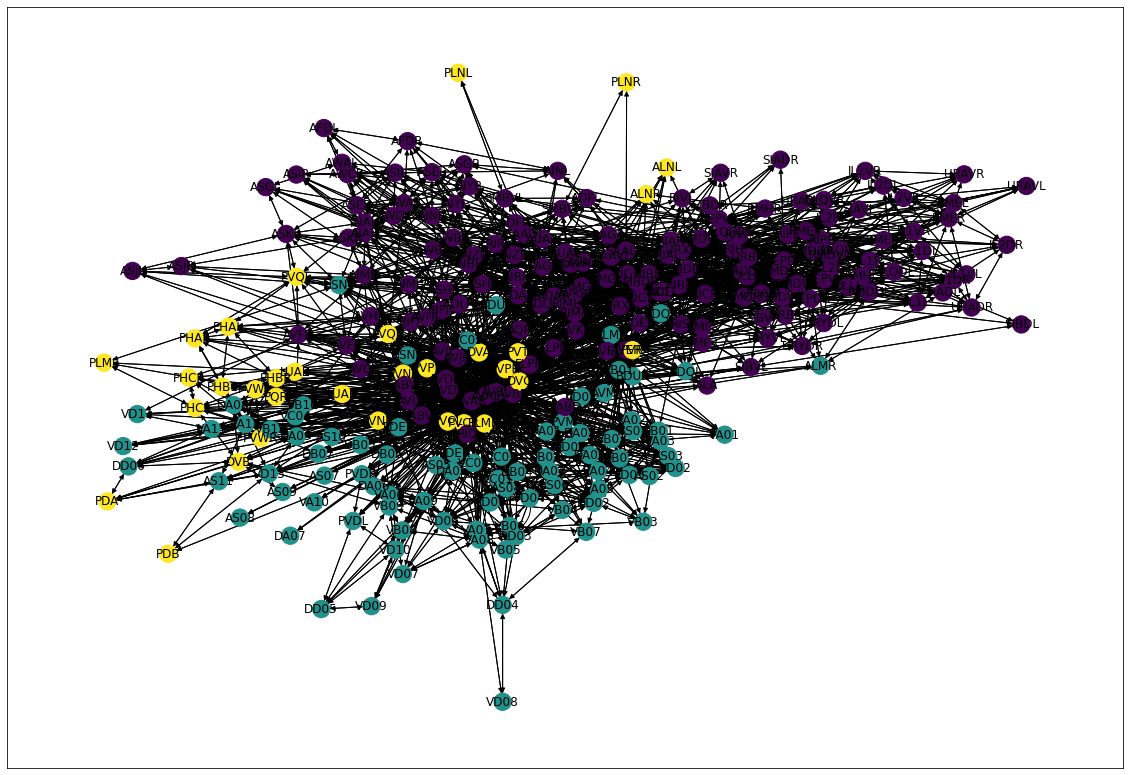

In [4]:
#plot the graph with colors correspoded to types (positions)
#Head neurons have Purple color  
#Middle neurons have Blue color
#Tail neurons have Yellow color

neuron_type_col = {} #neuron_type_col[neuron] = color (from 0 to 1)
neuron_col = [] #neuron_col[id of neuron] = color (from 0 to 1) - just colors

for neuron in nodes:
    neuron_type_col[neuron] = type_to_id[neuron_type[neuron]]/2 #3 colors: 0, 0.5 and 1
    neuron_col.append(neuron_type_col[neuron])

print('SIBDL', '-', neuron_type['SIBDL'], ', VD08', '-', neuron_type['VD08'], ', PLNR', '-', neuron_type['PLNR'])
plt.figure(figsize = (20, 14))

nx.draw_networkx(G_d, node_color = neuron_col)
plt.show()

In [5]:
from numpy import linalg as LA

#removing self-loops
print("Number of edges before selfloop correction = ", len(G_u.edges()))
G_u.remove_edges_from(nx.selfloop_edges(G_u))
print("Number of edges after selfloop correction = ", len(G_u.edges()))

#calculate laplacian matrix
L_rw = nx.laplacian_matrix(G_u).toarray()

l,v = LA.eig(L_rw) #eigenvalues and eigenvectors

min_ind = [np.argmin(l)] #indexes of first minimum eigenvalues
min_l = [l[min_ind[-1]]] #first minimum eigenvalues
min_v = [v[min_ind[-1]]] #eigenvectors for first minimum eigenvalues

l_new = list(l)
v_new = list(v)
for j in range(5):
    l_new.pop(min_ind[-1])
    v_new.pop(min_ind[-1])
    min_ind.append(np.argmin(l_new))
    min_l.append(l_new[min_ind[-1]])
    min_v.append(v_new[min_ind[-1]])
    
#calculate normalized laplacian matrix
L_nrw = nx.normalized_laplacian_matrix(G_u).toarray()

ln,vn = LA.eig(L_nrw) #eigenvalues and eigenvectors

min_ind = [np.argmin(ln)]  #indexes of first minimum eigenvalues
min_ln = [ln[min_ind[-1]]] #first minimum eigenvalues
min_vn = [vn[min_ind[-1]]] #eigenvectors for first minimum eigenvalues

l_new = list(ln)
v_new = list(vn)
for j in range(5):
    l_new.pop(min_ind[-1])
    v_new.pop(min_ind[-1])
    min_ind.append(np.argmin(l_new))
    min_ln.append(l_new[min_ind[-1]])
    min_vn.append(v_new[min_ind[-1]])

Number of edges before selfloop correction =  2290
Number of edges after selfloop correction =  2287


<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
<class 'networkx.utils.decorators.argmap'> compilation 16:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


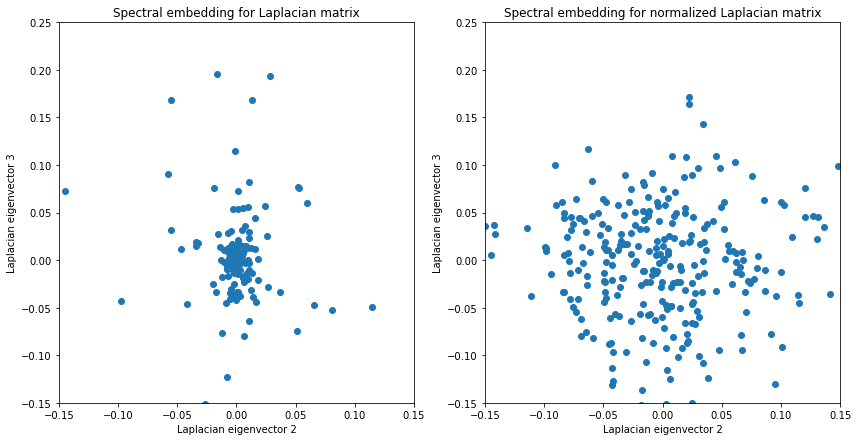

In [10]:
#plot spectral embeddings for neurons corresponded to 2 and 3 eigenvectors (for normalized Laplacian and common)
#print("Purple-Head\nBlue-middle\nYellow-Tail")
plt.figure(figsize=(14, 7))
set_range = True #plot in range ([-0.15, 0.15], [-0.15, 0.25])

plt.subplot(1, 2, 1)
plt.title("Spectral embedding for Laplacian matrix", y = 1)
plt.xlabel("Laplacian eigenvector 2")
plt.ylabel("Laplacian eigenvector 3")
if set_range:
    plt.xlim([-0.15, 0.15])
    plt.ylim([-0.15, 0.25])
plt.scatter(min_v[1], min_v[2]) #, c = [type_to_id[neuron_type[n]]/2 for n in G_u.nodes()])

plt.subplot(1, 2, 2)
plt.title("Spectral embedding for normalized Laplacian matrix", y = 1)
plt.xlabel("Laplacian eigenvector 2")
plt.ylabel("Laplacian eigenvector 3")
if set_range:
    plt.xlim([-0.15, 0.15])
    plt.ylim([-0.15, 0.25])
plt.scatter(min_vn[1], min_vn[2]) #, c = [type_to_id[neuron_type[n]]/2 for n in G_u.nodes()])

In [7]:
print(np.sum(np.array(min_v[1])**2), ", ", np.sum(np.array(min_v[2])**2))
print(np.sum(np.array(min_vn[1])**2), ", ", np.sum(np.array(min_vn[2])**2))

1.0000000000000138 ,  0.999999999999967
1.0000000000000482 ,  1.0000000000000766
